In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time
from IPython.display import clear_output

import itertools

import tensorflow as tf

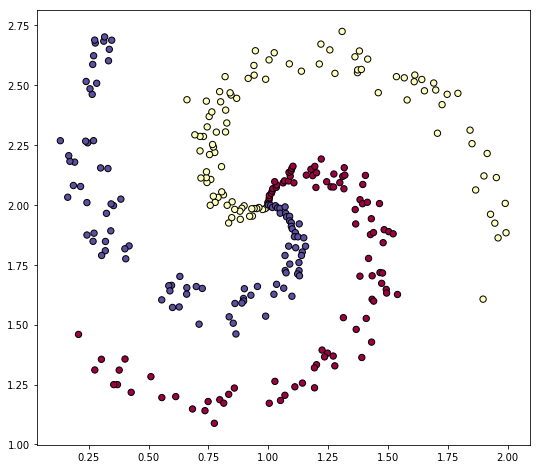

In [2]:
N = 100 # number of points per class
D = 2 # dimensionality
p = 4 # polynomial degree
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
X[:, 0] += 1
X[:, 1] += 2
# lets visualize the data:
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral, edgecolors="black")
ax = plt.gca()
ax.set_aspect("equal")
plt.show()

In [3]:
def featurize(x, p=1):
    return np.product(np.power(x, list(x for x in itertools.product(range(p+1), repeat=2) if sum(x) <=p)), axis=-1)

In [4]:
h=0.02

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))
xx_yy_features = [featurize(x, p) for x in 
         np.column_stack([xx.ravel(), yy.ravel()])]

def plot():
      
    Z = sess.run(t_prediction, 
                 feed_dict={t_x: xx_yy_features})
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10,8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, 
                cmap=plt.cm.Spectral, edgecolors="black")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.gca().set_aspect("equal")
    plt.show()

In [5]:
X_big = np.stack([featurize(x, p) for x in X]); X_big.shape, p

((300, 15), 4)

### Polynomial SoftMax Classifier

In [6]:
reg = 1e-3 # regularization strength

# Encapsulating all ops into scopes, making Tensorboard's Graph
# Visualization more convenient
with tf.name_scope("Model"):
    t_x = tf.placeholder(tf.float32, shape=[None, X_big.shape[1]])
    t_y = tf.placeholder(tf.int32, shape=[None])
    W = tf.Variable(tf.random_normal([X_big.shape[1], K]))
    t_scores = tf.matmul(t_x, W)
    t_prediction = tf.argmax(t_scores, axis=-1, output_type=tf.int32)

with tf.name_scope("Loss"):
    t_loss_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=t_y, logits=t_scores)
    t_loss_reg = tf.reduce_sum(W * W) * reg
    t_loss = tf.reduce_mean(t_loss_entropy + t_loss_reg)

with tf.name_scope("Optimizer"):
    optimizer = tf.train.AdamOptimizer()
    
    t_grads = tf.gradients(t_loss, tf.trainable_variables())
    grads_and_vars = list(zip(t_grads, tf.trainable_variables()))
    train_op = optimizer.apply_gradients(grads_and_vars)
    

with tf.name_scope("Accuracy"):
    t_acc = tf.reduce_mean(tf.cast(tf.equal(t_prediction, t_y), tf.float32))
    

In [7]:
tf.trainable_variables()

[<tf.Variable 'Model/Variable:0' shape=(15, 3) dtype=float32_ref>]

In [8]:
# Create a summary to monitor cost tensor
tf.summary.scalar("loss", t_loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", t_acc)
# Create summaries to visualize weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
# Summarize all gradients
for grad, var in grads_and_vars:
    tf.summary.histogram(var.name + '/gradient', grad)
    
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

INFO:tensorflow:Summary name Model/Variable:0 is illegal; using Model/Variable_0 instead.
INFO:tensorflow:Summary name Model/Variable:0/gradient is illegal; using Model/Variable_0/gradient instead.


In [9]:
# op to write logs to Tensorboard
summary_writer = tf.summary.FileWriter(logdir="/tmp/tf_logs/",
                                        graph=tf.get_default_graph())

In [18]:
if "sess" in dir():
    sess.close()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
iteration = 0

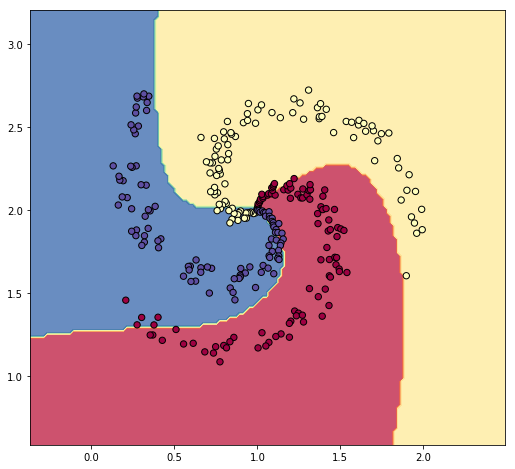

iteration 9800:	loss 0.461737	acc 0.800000


In [21]:
for i in range(10000):
    loss, acc, _, summary = sess.run([t_loss, t_acc, train_op, merged_summary_op], 
                                     feed_dict={t_x:X_big, t_y:y})
    iteration += 1
    summary_writer.add_summary(summary, iteration)

#     time.sleep(0.0000001)
    
    if i % 200 == 0:
        clear_output(wait=True)
        plot()
        print("iteration %d:\tloss %f\tacc %f" % (i, loss, acc))


In [22]:
# evaluate training set accuracy
print('training accuracy: %.2f%%' % 
      (100*sess.run(t_acc, feed_dict={t_x:X_big, t_y:y})))

training accuracy: 80.33%


Run the command line:

`tensorboard --logdir=/tmp/tf_logs`